# Homework 3 - Regularized Regression

## Data Analysis
### FINM August Review
#### Mark Hendricks
#### hendricks@uchicago.edu

***

# Penalized Regression

In [3]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import sklearn.metrics
import statsmodels as sm
from matplotlib import pyplot as plt

$$\newcommand{\nsecs}{450}$$
$$\newcommand{\target}{GLD}$$
$$\newcommand{\spy}{\text{spy}}$$
$$\newcommand{\hyg}{\text{hyg}}$$

## Data
* This homework uses the file, `data/spx_weekly_returns_single_names.xlsx`.
* Find the data in the Github repo associated with the module, (link on Canvas.)

The data file contains...
* Return rates, $r^{\target}_t$, for the \target, (an ETF,) which tracks the returns on gold.
* Return rates, $r^i_t$, for $\nsecs$ single-name equities. 

#### Note
These are less than 500 return series in the sample due to filtering out securities with insufficient return histories.

In [4]:
rets_spx = pd.DataFrame(pd.read_excel("../data/spx_returns_single_names.xlsx", sheet_name="s&p500 rets")).set_index("date")
rets_bench = pd.DataFrame(pd.read_excel("../data/spx_returns_single_names.xlsx", sheet_name="benchmark rets")).set_index("date")

## Model
Consider a regression of $\target$, denoted $r^{\target}$, on all $\nsecs$ returns of the S&P 500 stocks.

$$
r^{\target}_t = \alpha + \sum_{j=1}^k \beta^j r^j_t + \epsilon_t
\label{eq:REG}
$$

We refer to this equation below as the `MODEL`.

***

# 1. 

Estimate the `MODEL` with OLS.

#### Note
For this OLS estimation, along with the estimations below, try using scikit-learn in Python

`from sklearn import LinearRegression Lasso Ridge`

For OLS specifically, try

`model_ols = LinearRegression().fit(X,y)`


In [5]:
model_ols = linear_model.LinearRegression(fit_intercept=True).fit(rets_spx, rets_bench[['GLD']])

### 1.1. 
Report the R-squared.


In [6]:
# Predict values
predictions = model_ols.predict(rets_spx)

# Calculate R-squared
r2_ols = sklearn.metrics.r2_score(rets_bench[['GLD']], predictions)

print(f"R-squared: {r2_ols:.4f}")


R-squared: 1.0000


### 1.2. 
Which factors have the largest betas in explaining $r^{\target}$?


In [7]:
betas = model_ols.coef_
betas_df = pd.DataFrame(betas, columns=rets_spx.columns, index=['Beta']).T

print("5 largest betas:")
betas_df.loc[betas_df['Beta'].abs().sort_values(ascending=False).index, 'Beta'].head(5)


5 largest betas:


AEP   -0.804002
TT    -0.594463
LMT    0.577376
AEE    0.556533
T     -0.482145
Name: Beta, dtype: float64

### 1.3. 
Calculate $\beta^j \sigma^j$ for each regressor. Which of these is largest in magnitude, and thus most influential in explaining $r^{\target}$?

#### Note
The beta being large may simply be because the regressor volatility is small. By scaling by the volatility, we get a better idea of which regressor is driving the most variation.


In [8]:
# Calculate sigma for each regressor
betas_df['sigma'] = rets_spx.std()
betas_df['beta_sigma'] = betas_df['Beta']*betas_df['sigma']

print("These are the 5 largest betas; adjusted by volatility")
#betas_df.abs().sort_values(by='beta_sigma', ascending=False).head(5)
betas_df.loc[betas_df['beta_sigma'].abs().sort_values(ascending=False).index, 'beta_sigma'].head(5)


These are the 5 largest betas; adjusted by volatility


AEP    -0.024883
TT     -0.023143
COF     0.019766
WELL    0.019457
DFS    -0.019068
Name: beta_sigma, dtype: float64

We can note that AEP and TT are still the largest beta, but the next three largest betas are different

### 1.4. 
Report the matrix condition number of $R'R$, where $R$ denotes the matrix of single-name equity return data. Why should this condition number give us pause about trusting the OLS estimates out-of-sample?

#### Note
To get the matrix condition number, consider using, in Python, `numpy.linalg.cond()`.

In [9]:
print(f"The estimated matrix condition number is {np.linalg.cond(rets_spx.T @ rets_spx):.4f}")


The estimated matrix condition number is 26444718373225488384.0000


The condition number of a function measures how much the output value of the function can change for a small change in the input argument. In this case, our condition number is small ~ 2.6, so this means that the output doesn't change too much with changes in the inputs. This can give us pause about trusting the OLS estimates out of sample because we found that they won't change that much.

#  2. 

Estimate `MODEL` with Ridge Regression. 
* Use a penalty of `ALPHA=0.5` in the estimation.
* Try using `est = Ridge(alpha=ALPHA).fit(X,y)`



In [10]:
ALPHA = 0.5
est_ridge = linear_model.Ridge(alpha = ALPHA).fit(rets_spx, rets_bench[['GLD']])

### 2.1.
Report the R-squared.

In [11]:
# Use the built in function score
r2_ridge = est_ridge.score(rets_spx, rets_bench[['GLD']])
print(f"The estimated R-Squared is {r2_ridge:.4f}")

The estimated R-Squared is 0.7396


### 2.2.
Based on $\beta^j \sigma^j$, which factor is most influential for $r^{\target}$?


In [12]:
betas_ridge = pd.DataFrame(est_ridge.coef_, columns=rets_spx.columns, index=['Beta']).T
betas_ridge['sigma'] = rets_spx.std()
betas_ridge['beta_sigma'] = betas_ridge['Beta']*betas_ridge['sigma']

print("These are the 5 largest betas; adjusted by volatility")
betas_ridge.loc[betas_ridge['beta_sigma'].abs().sort_values(ascending=False).index, 'beta_sigma'].head(5)


These are the 5 largest betas; adjusted by volatility


NEM     0.005940
FCX     0.002148
SCHW   -0.001439
CCL    -0.001248
RJF    -0.001197
Name: beta_sigma, dtype: float64

### 2.3.
Report the matrix condition number of the $R'R$.


In [13]:
#print(f"The estimated matrix condition number is {np.linalg.cond(rets_spx.T @ rets_spx)}")

# Test
mat_cond_ridge = np.linalg.cond(rets_spx.T @ rets_spx + np.diag(np.ones(rets_spx.shape[1])) * ALPHA)
print(f"The estimated matrix condition number is {mat_cond_ridge}")

The estimated matrix condition number is 307.5445419148743


### 2.4.
How many regressors have a non-zero beta estimates? 

In [14]:
print(f"{np.sum(betas_ridge['Beta']!= 0)} have a non-zero beta estimate, that is, all parameters.")

446 have a non-zero beta estimate, that is, all parameters.


This is expected because the functional form of ridge regression used L2 shrinkage, so you won't have any parameter with a zero beta estimate.

***

# 3. 

Estimate `MODEL` with LASSO Regression. 
* Use a penalty of `ALPHA=7e-5` in the estimation.
* Try using `est = Lasso(alpha=ALPHA).fit(X,y)`



In [15]:
ALPHA = 7e-5
est_lasso = linear_model.Lasso(alpha=ALPHA).fit(rets_spx, rets_bench[['GLD']])

### 3.1.
Report the R-squared.

In [16]:
# Use the built in function score
r2_lasso = est_lasso.score(rets_spx, rets_bench[['GLD']])
print(f"The estimated R-Squared is {r2_lasso:.4f}")

The estimated R-Squared is 0.5497


### 3.2.
Based on $\beta^j \sigma^j$, which factor is most influential for $r^{\target}$?


In [17]:
betas_lasso = pd.DataFrame(est_lasso.coef_.flatten(), columns=['Beta'], index=rets_spx.columns)

betas_lasso['sigma'] = rets_spx.std()
betas_lasso['beta_sigma'] = betas_lasso['Beta']*betas_lasso['sigma']

print("These are the 5 largest betas; adjusted by volatility")
betas_lasso.loc[betas_lasso['beta_sigma'].abs().sort_values(ascending=False).index, 'beta_sigma'].head(5)


These are the 5 largest betas; adjusted by volatility


NEM     0.011731
SCHW   -0.001231
ENPH    0.001149
BA      0.000771
RJF    -0.000593
Name: beta_sigma, dtype: float64

### 3.3.
Report the matrix condition number of the $R'R$.


In [18]:
mat_cond_lasso = np.linalg.cond(rets_spx.loc[:,(betas_lasso['Beta']!= 0)].T @ rets_spx.loc[:,(betas_lasso['Beta']!= 0)])
print(f"The estimated matrix condition number is {mat_cond_lasso}")

The estimated matrix condition number is 49.1361128052772



### 3.4.
How many regressors have a non-zero beta estimates? 

In [19]:
print(f"We have {np.sum(betas_lasso['Beta'] != 0)} non-zero parameters in the lasso model as expected because LASSO uses a L1 penalization")

We have 11 non-zero parameters in the lasso model as expected because LASSO uses a L1 penalization


***

# 4.

How do the estimations compare across the three methods?


The estimates differ significantly. For example, the largest coefficients (in absolute value) in the OLS are: AEP, TT, COF, WELL, DFS; while for the regularization models: RIDGE: NEM, FCX, SCHW, CCL, RJF; LASSO: NEM, SCHW, ENPH, BA, RJF. The coefficients are very different, and LASSO only have 11 non-zero betas, while the other regression have non-zero betas for every stock in the SP500. 

### 4.1.
Create a histogram of estimated betas across the three methods, (OLS, Ridge, LASSO.) 

Are they all nonzero? Are there positive and negative values? Do they range widely in magnitude? 


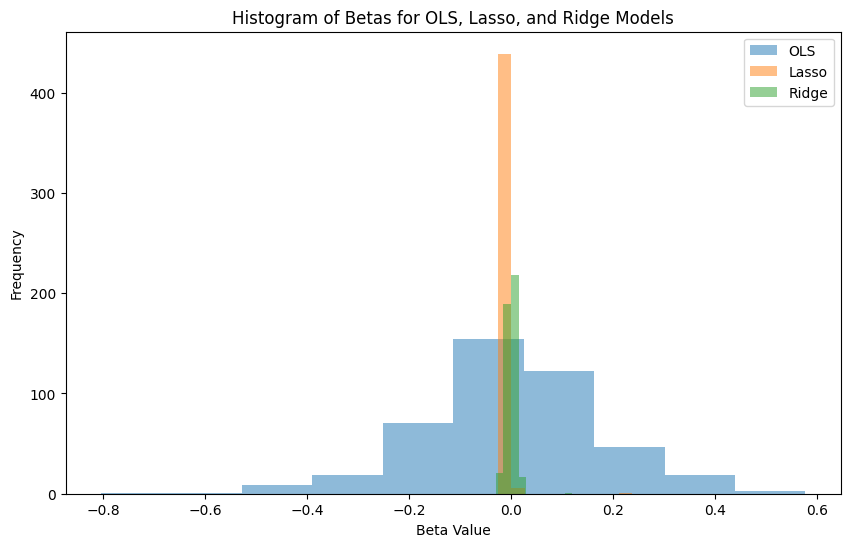

In [20]:
df_betas = pd.DataFrame({
    'OLS': betas_df['Beta'],
    'Lasso': betas_lasso['Beta'],
    'Ridge': betas_ridge['Beta']
})

# Melt DataFrame for plotting
df_melted = df_betas.melt(var_name='Model', value_name='Beta')

# Plot histogram
plt.figure(figsize=(10, 6))
for model in df_betas.columns:
    plt.hist(df_betas[model], bins=10, alpha=0.5, label=model)

plt.xlabel('Beta Value')
plt.ylabel('Frequency')
plt.title('Histogram of Betas for OLS, Lasso, and Ridge Models')
plt.legend()
plt.show()

There are both positive and negative values on all models, and they have a wide range for OLS, while for LASSO and RIDGE they have similar values, that is, a tighter range of values. Ridge and OLS have all non-zero parameters, but LASSO have a lot of zero parameters, as expected. 


### 4.2.
Which has the largest R-squared? Is this a surprise?

In [21]:
print(f"As expected, OLS {r2_ols} is larger than both RIDGE {r2_ridge:.3f} and LASSO {r2_lasso:.3f}")

As expected, OLS 1.0 is larger than both RIDGE 0.740 and LASSO 0.550


***

# 5.

Try using cross-validation (with K-folds) to estimate the penalty parameter for Ridge and LASSO.

Estimate this CV using two functions from  `sklearn.linear_model`
* RidgeCV
* LassoCV

Feel free to use the default parameters, including the default number of folds.

Report the CV penalty parameter for Lasso and Ridge.

In [22]:
cv_ridge = sklearn.linear_model.RidgeCV().fit(rets_spx, rets_bench[['GLD']])
ridge_penalty = cv_ridge.alpha_


In [23]:
cv_lasso = sklearn.linear_model.LassoCV().fit(rets_spx, rets_bench[['GLD']])
lasso_penalty = cv_lasso.alpha_

/Users/charleston/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charleston/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-05, tolerance: 1.299e-05
  model = cd_fast.enet_coordinate_descent(
/Users/charleston/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.025e-0

In [24]:
print(f"RIDGE penalty parameter estimated from cross validation is {ridge_penalty}, while LASSO penalty parameter estimated from cross validation is {lasso_penalty}")

RIDGE penalty parameter estimated from cross validation is 1.0, while LASSO penalty parameter estimated from cross validation is 4.195194791405444e-05


***

# 6.

Use your estimations based on data through 2022 to fit the model for 2023-2024. Use the CV penalty parameters (from the previous problem) for Ridge and Lasso.

* What is the r-squared in these out-of-sample fits?


#### Note
Doing this is really easy in Python. For instance, for the LASSO estimation, you could try

`est = Lasso(alpha=ALPHA).fit(X,y)`

`score_is = est.score(X_insamp,y_insamp)`

`score_oos = est.score(X_oos,y_oos)`

Which method does better out-of-sample?

***

In [25]:
# Filter in sample
X_insamp = rets_spx.loc[rets_spx.index < "2023-01-01"]
y_insamp = rets_bench[['GLD']].loc[rets_bench.index < "2023-01-01"]

# Filter out of sample
X_oos = rets_spx.loc[rets_spx.index >= "2023-01-01"]
y_oos = rets_bench[['GLD']].loc[rets_bench.index >= "2023-01-01"]

In [26]:
# LASSO
lasso_model = linear_model.Lasso(alpha=lasso_penalty).fit(X_insamp,y_insamp)

lasso_score_is = lasso_model.score(X_insamp,y_insamp)

lasso_score_oos = lasso_model.score(X_oos,y_oos)

lasso_score_is, lasso_score_oos


(0.6284398615836027, 0.462719446915104)

In [27]:
# RIDGE
ridge_model = linear_model.Ridge(alpha=ridge_penalty).fit(X_insamp,y_insamp)

ridge_score_is = ridge_model.score(X_insamp,y_insamp)

ridge_score_oos = ridge_model.score(X_oos,y_oos)

ridge_score_is, ridge_score_oos

(0.6616561080581611, 0.35599569449854607)

According to the R-Squared, LASSO does better out of sample than RIDGE. 